In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from differentiable_lensing import DifferentiableLensing

In [2]:
device = 'cpu'


Initialising the DifferentiableLensing module to a lower resolution for the purposes of demonstration

In [3]:
downscale_fraction = 2
lensing_module = DifferentiableLensing('cpu', target_resolution=0.262*downscale_fraction, target_shape=(256//downscale_fraction)+1, alpha=None)

Initialising the deflection field

In [4]:
alpha_r = 7
alpha = lensing_module.construct_sis(alpha_r)
lensing_module.set_alpha(alpha)

In [5]:
theta_x, theta_y = lensing_module.theta_x[0], lensing_module.theta_y[0]
beta_x, beta_y = lensing_module.backward_lensing(theta_x, theta_y, alpha)

In [6]:
M = torch.load('sparse_grid_fracs.pt')

Loading datasets

In [7]:
device = 'cpu'
train_smooth_images = np.load('datasets/sources/lensing_images_smooth_7.npy')
train_spiral_images = np.load('datasets/sources/lensing_images_spiral_7.npy')
train_smooth = torch.tensor(train_smooth_images, dtype=torch.float32, device=device)
train_spiral = torch.tensor(train_spiral_images, dtype=torch.float32, device=device)
train_smooth, train_spiral = torch.permute(train_smooth, (0, 3, 1, 2)), torch.permute(train_spiral, (0, 3, 1, 2))
demo_smooth, demo_spiral = torch.nn.functional.interpolate(train_smooth, scale_factor=1/downscale_fraction), torch.nn.functional.interpolate(train_spiral, scale_factor=1/downscale_fraction)

Plotting lensed images for reference

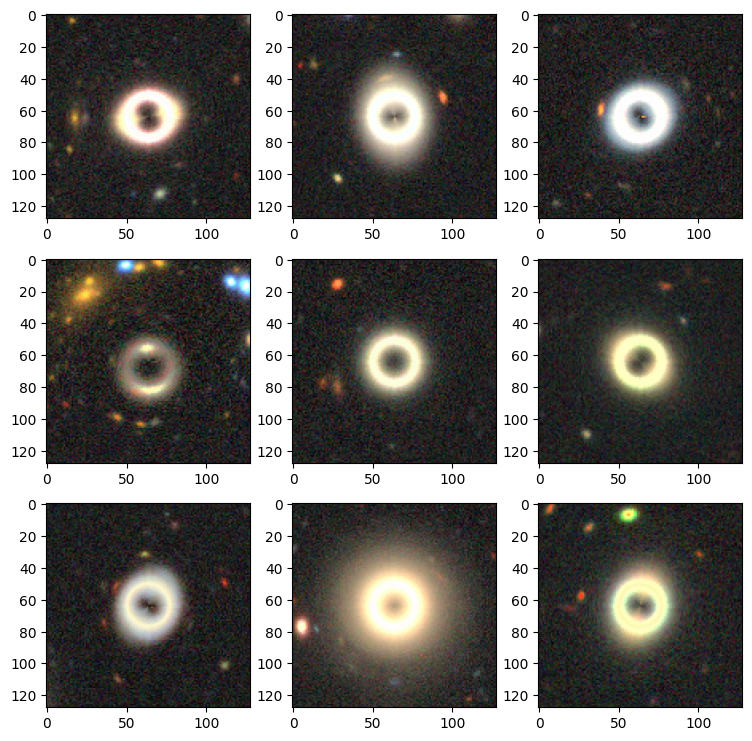

In [8]:
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(demo_smooth[i+3*j].permute(1,2,0).numpy().astype('int'))

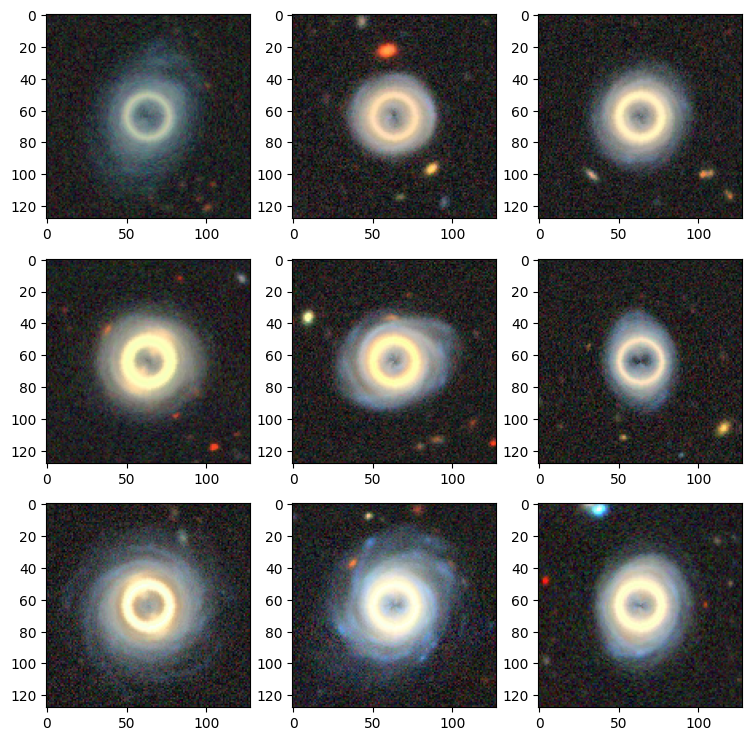

In [9]:
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(demo_spiral[i+3*j].permute(1,2,0).numpy().astype('int'))

Reconstructing sources

In [10]:
image_shape = demo_smooth.shape[-1]
reconstructed_sources_smooth = lensing_module.reconstruct_source_sparse(demo_smooth, M.abs(), (image_shape, image_shape, image_shape, image_shape))
reconstructed_sources_spiral = lensing_module.reconstruct_source_sparse(demo_spiral, M.abs(), (image_shape, image_shape, image_shape, image_shape))

In [11]:
intensity_mask_smooth = reconstructed_sources_smooth > 255*0.95
intensity_mask_spiral = reconstructed_sources_spiral > 255*0.95
masked_smooth, masked_spiral = reconstructed_sources_smooth, reconstructed_sources_spiral
masked_smooth[intensity_mask_smooth] = 255*0.95
masked_spiral[intensity_mask_spiral] = 255*0.95

Plotting the reconstructed sources

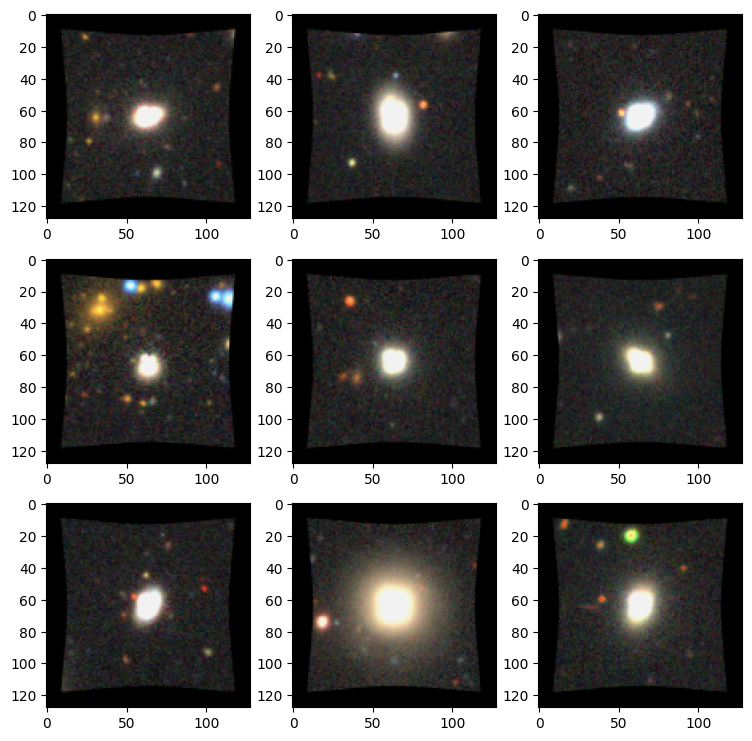

In [12]:
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((masked_smooth[i+3*j]).permute(1,2,0).numpy().astype('int'))

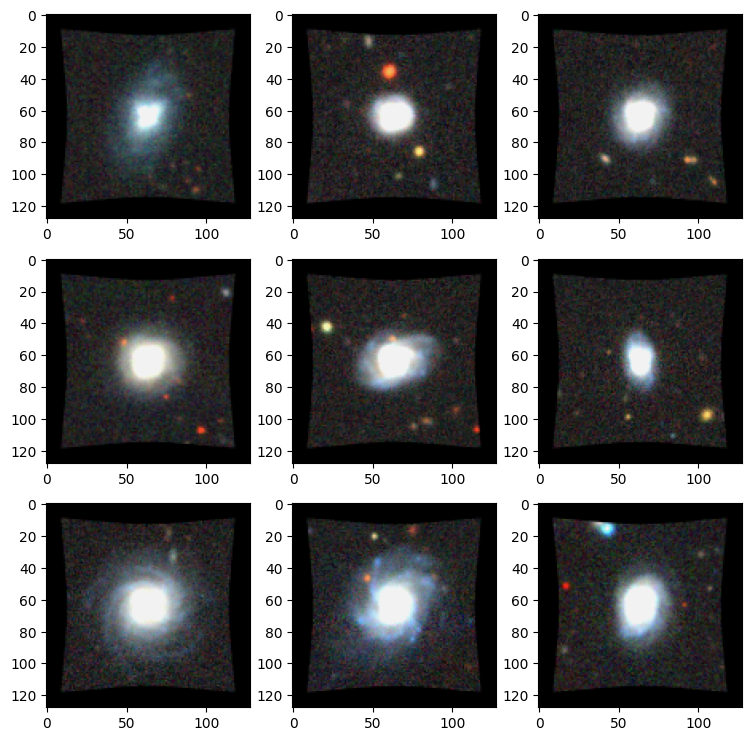

In [13]:
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((masked_spiral[i+3*j]).permute(1,2,0).numpy().astype('int'))